In [186]:
import numpy as np
from numpy import interp
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## Market and Credit Model

In [106]:
r = 0.02  # Taux sans risque
S0 = 100  # Prix initial de l'actif sous-jacent
S_bar = 134  # Prix d'exercice
kappa = 0.12  # Drift
sigma = 0.2  # Volatilité
hl = 0.25  # 3 mois en années
T = 5  # Maturité
delta = 1/52 # one week in years
gamma = 0.01 # exponential default times 100 bps 

In [3]:
def black_scholes_paths(S0, r, sigma, T, dt, N_paths):
    """Génère des trajectoires de Black-Scholes par Euler-Maruyama"""
    N_steps = int(T / dt)
    S = np.zeros((N_steps + 1, N_paths))
    S[0] = S0
    for t in range(1, N_steps + 1):
        Z = np.random.normal(0, 1, N_paths)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

## Black-Scholes Simulation

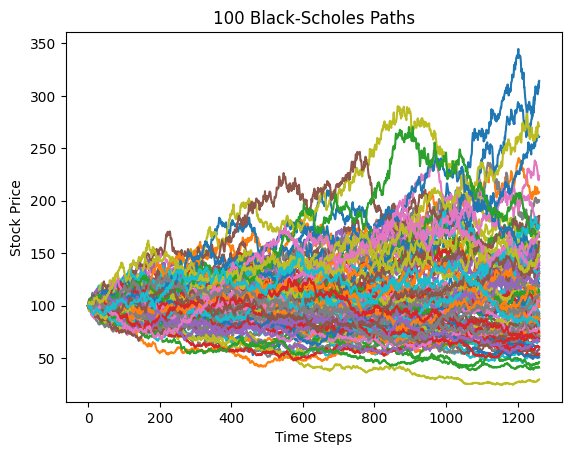

In [4]:
# Plot 100 paths
N_paths = 100
T = 5
dt = 1/252

paths = black_scholes_paths(S0, r, sigma, T, dt, N_paths)
plt.plot(paths)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('100 Black-Scholes Paths')
plt.show()

## Mark-to-Market computation

In [170]:
N_paths = 5000
dt = 1/252  # Pas journalier
t_grid = np.linspace(0, T, int(T / hl) + 1)
S_paths = black_scholes_paths(S0, r, sigma, T, dt, N_paths)
Nom = np.exp(-r * T) / (sum( [ np.exp(- r * (T - t_grid[l])) * ( np.exp(kappa * t_grid[l-1]) * S0 - S_bar) for l in range( 1 , len(t_grid)) ] ) * hl)

# 3. Calcul du processus MtM

def MtM(t, S_bar=S0):
    
    step = 1/dt
    beta_t = np.exp(r * (T - t))
    betas = np.exp(- r * (T - t_grid) )
    # The nominal (Nom) of the swap is set so that each leg has a time-0 mark-to-market of 1
    Nom = np.exp(-r * T) / (sum( [ betas[l] * ( np.exp(kappa * t_grid[l-1]) * S_paths[0] - S_bar) for l in range( 1 , len(t_grid)) ] ) * hl)

    # l_t is the index of t_grid such that t_grid[l_t - 1] <= t < t_grid[l_t]
    l_t = min( np.argmin(np.abs(t_grid - t)) +  1, 20)

    S_t = S_paths[int(t * step)] # S_t = S(t)
    S_hat = np.exp(-kappa * t) * S_t 

    Σ = sum( [ betas[l] * ( np.exp(kappa * t_grid[l-1]) * S_hat - S_bar) for l in range(l_t + 1, len(t_grid)) ] )

    MtM = Nom * beta_t * hl * ( betas[l_t] * (S_paths[int(t_grid[l_t - 1] * step)] - S_bar) + Σ)
    
    return MtM


In [6]:
MtMs = [MtM(t) for t in np.linspace(0, T, int(T / dt) + 1)]

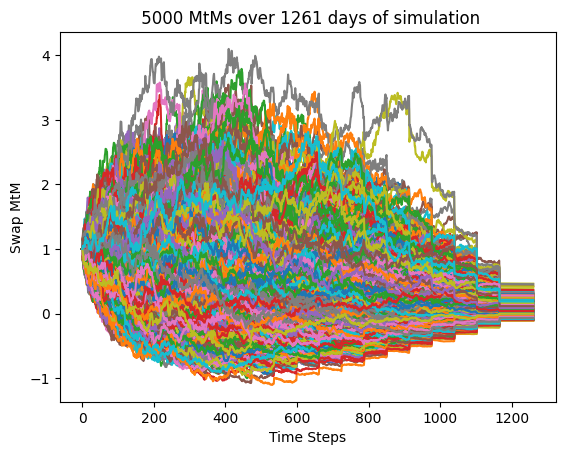

In [7]:
# Plot MtMs

plt.plot(MtMs)
plt.xlabel('Time Steps')
plt.ylabel('Swap MtM')
plt.title(f' {len(MtMs[0])} MtMs over {len(MtMs)} days of simulation')
plt.show()

## 5.1 Warm up CVA w/o RIM

In [ ]:
# Auxiliary methods
def f(t):
    betas = np.exp(- r * (T - t_grid) )
    # l_t_delat is the index of t_grid such that t_grid[l_t - 1] <= t + delta < t_grid[l_t]
    l_t_delta =  min( np.argmin(np.abs(t_grid - (t + delta) )) +  1, 20)
    Σ = sum( [ betas[l] * ( np.exp(kappa * t_grid[l-1]) * hl) for l in range(l_t_delta + 1, len(t_grid)) ] )
    return Σ


def A(t):
    sqrt_delta = np.sqrt(delta)
    term1 = norm.cdf(sigma * sqrt_delta / 2)
    term2 = norm.cdf(-sigma * sqrt_delta / 2)
    return f(t) * (term1 - term2)

def S_hat(t, S0):
    S_t = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * np.sqrt(t) * np.random.normal(0, 1))
    return np.exp(-kappa * t) * S_t


In [ ]:
# Computing postive part of gap risk with equation (2)

def gap_risk(t, S_hat_t):
    S_hat_t_delta = S_hat(delta, S_hat_t)
    return max(0, Nom * f(t) * (S_hat_t_delta - S_hat_t))

# Computing the left-hand side and right-hand side of equation (4)
def lhs_estimation(t, S_hat_t, N = 1000):
    return np.mean([gap_risk(t, S_hat_t) for _ in range(N)])

# Computing the right-hand side of equation (4)
def rhs_computation(t, S_hat_t):
    return Nom * A(t) * S_hat_t


In [ ]:
time = np.linspace(0, T, int(T / dt) + 1)
S_hats = S_hat(time, S0)

lhs = [ lhs_estimation(t, S_hats[int(t*(1/dt))]) for t in tqdm( time, desc='LHS Estimation') ]
rhs = [ rhs_computation(t, S_hats[int(t*(1/dt))]) for t in time ]

plt.plot(lhs, label='LHS', color='blue')
plt.plot(rhs, label='RHS', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Gap Risk')
plt.title('Gap Risk Estimation')
plt.legend()
plt.show()

### 1 - Linear regress vs. train a (one layer) linear neural network 
to learn the left-hand side in (4) at grid times t.

In [175]:
# regression model vs 1-Layer NN with data from lhs 
data = {'y' : lhs, 'x1': S_hats, 'x2': time}
df = pd.DataFrame(data)

X = df[['x1', 'x2']].values
y = df['y'].values
df.head()

,y,x1,x2
0,0.720770,100.000000,0.000000
1,0.714991,100.727288,0.003968
2,0.799754,101.001910,0.007937
3,0.681028,101.201929,0.011905
4,0.648268,101.363284,0.015873


In [183]:

reg_linear = LinearRegression()
reg_linear.fit(X, y)
y_pred_linear = reg_linear.predict(X)
y_pred_linear

array([ 0.80067727,  0.7789162 ,  0.76988808, ..., -0.05817576,
       -0.05873277, -0.05928997])

In [ ]:


# 1-Layer NN
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)
    
# Hyperparameters
input_size = 2  # x1 and x2
output_size = 1  # y
num_epochs = 1000
learning_rate = 0.01
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoader
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function and optimizer
model = SimpleNN(input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs), desc='Training NN'):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()


Training NN: 100%|██████████| 1000/1000 [00:19<00:00, 50.51it/s]


In [182]:

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_tensor).cpu().numpy().flatten()

y_pred_nn

array([ 7.0288360e-01,  7.0155334e-01,  7.0068938e-01, ...,
        4.1589703e-04, -1.3787019e-04, -6.9169700e-04], dtype=float32)

### - 2 Validate by (all at each grid time t)
 - a. the formula (4),
 - b. twin Monte Carlo for conditional expectations,
 - c. nested Monte Carlo

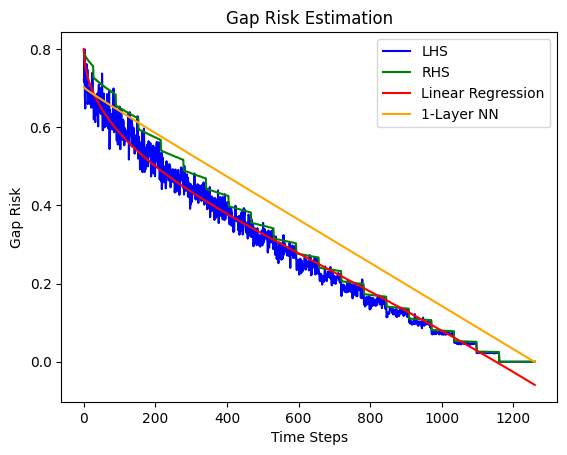

In [184]:

# Plotting the results
plt.plot(lhs, label='LHS', color='blue')
plt.plot(rhs, label='RHS', color='green')
plt.plot(y_pred_linear, label='Linear Regression', color='red')
plt.plot(y_pred_nn, label='1-Layer NN', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('Gap Risk')
plt.title('Gap Risk Estimation')
plt.legend()
plt.show()


### 3 - Deduce CVA0 by numerical integration and Monte Carlo
based on your predictors plugged in the last line in (7). Validate the result by the explicit formula (6).

In [211]:
# Define gamma_1(t) as a constant function

def gamma_1(t):
    return gamma

# Compute the integral of gamma_1(s) from 0 to t (simplified since gamma is constant)
def integral_gamma_1(t):
    return gamma * t

# Define the explicit formula for CVA_0
def CVA_explicit(Nom, S0):
    def integrand(t):
        A_t = A(t)
        exp_term = np.exp(-integral_gamma_1(t))
        return A_t * exp_term * gamma_1(t)
    
    result, _ = quad(integrand, 0, T)
    return Nom * S0 * result

# Monte Carlo simulation for CVA_0
def CVA_monte_carlo(N = 1000, regression = True):
    if regression:
        predictor = lambda s, t: reg_linear.predict([[s, t]])[0]
    else:
        predictor = lambda s, t: model(torch.tensor([[s, t]], dtype=torch.float32).to(device)).cpu().detach().numpy()[0][0]

    time = np.linspace(0, T, int(T / dt))

    cva_values = []
    for i in tqdm(range(N), desc ='CVA Monte Carlo Simulation'):
        def integrand(t):
            predictor_t = predictor( S_hat(t, S0) , t)
            return predictor_t * np.exp(-integral_gamma_1(t)) * gamma_1(t)
        
        result, _ = quad(integrand, 0, T)
        cva_values.append(result)
    
    return np.mean(cva_values)
    
    


In [212]:
import warnings
warnings.filterwarnings("ignore")

# Compute CVA using explicit formula
cva_explicit = CVA_explicit(Nom, S0)
print("CVA (Explicit Formula):", cva_explicit)

# Compute CVA using Monte Carlo
cva_monte_carlo = CVA_monte_carlo()
print("CVA (Monte Carlo):", cva_monte_carlo)

CVA (Explicit Formula): 0.020502321779606394


CVA Monte Carlo Simulation: 100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]

CVA (Monte Carlo): 0.028665481618176124
